In [27]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from geopy.distance import geodesic

from utils import evaluate_geolocation_classification, print_recall_at_thresholds, plot_recall_curve, plot_loss, plot_acc

In [28]:
gt_df = pd.read_csv("../../data/gt/datasetInfoClean.csv")
gt_test = pd.read_csv("../../data/gt/test_with_cells_osm_full.csv")
gt_train = pd.read_csv("../../data/gt/train_with_cells_osm_full.csv")
gt_eval = pd.read_csv("../../data/gt/val_with_cells_osm_full.csv")

pred_before = pd.read_csv("../../data/results/baseline/geolocations_uniform.csv")
pred_country_class = pd.read_csv("../../data/results/country_class/finetuned_predictions5_full.csv")
pred_admin1_class = pd.read_csv("../../data/results/admin1_class/finetuned_predictions4.csv")

In [29]:
print(gt_test["country_id"].value_counts())
print(gt_train["country_id"].value_counts())
print(gt_eval["country_id"].value_counts())

country_id
1    3463
4      48
0       1
5       1
Name: count, dtype: int64
country_id
4    3242
3    3149
0    1599
2     253
1      38
6      36
5       7
Name: count, dtype: int64
country_id
0    448
2     44
4     24
Name: count, dtype: int64


In [30]:
print(gt_test["admin1_id"].value_counts())
print(gt_train["admin1_id"].value_counts())
print(gt_eval["admin1_id"].value_counts())

admin1_id
7     2673
51     275
16      81
34      69
52      67
37      59
43      56
19      36
2       29
49      28
28      28
13      27
22      18
57      17
27      11
1        7
11       7
56       7
45       6
29       4
0        2
42       2
5        1
54       1
4        1
26       1
Name: count, dtype: int64
admin1_id
33    3146
19    1399
47    1311
45    1045
0      445
29     323
6      242
48      88
54      87
41      74
51      38
9       21
53      20
20      15
3       11
18      10
12      10
38       5
35       3
31       3
10       3
50       3
44       2
55       2
17       2
8        2
14       2
39       1
32       1
4        1
36       1
15       1
24       1
23       1
25       1
30       1
40       1
21       1
46       1
Name: count, dtype: int64
admin1_id
35    207
9     117
47    116
6      44
12     21
48      8
45      2
53      1
Name: count, dtype: int64


In [31]:
print(gt_test["admin2_id"].value_counts())
print(gt_train["admin2_id"].value_counts())
print(gt_eval["admin2_id"].value_counts())

admin2_id
42     2575
120     141
1        58
15       52
32       47
       ... 
14        1
36        1
125       1
10        1
11        1
Name: count, Length: 69, dtype: int64
admin2_id
25     1862
100    1391
26     1255
66      856
19      754
118     445
101     315
102     291
116     198
67      142
78      137
83       85
61       85
72       70
58       50
114      44
0        43
57       37
50       36
59       33
23       24
75       21
93       19
77       12
31       11
71       11
73       11
41       10
103      10
81        6
92        5
35        5
89        4
85        4
87        4
68        3
22        3
96        3
109       2
80        2
28        2
70        2
104       2
88        2
24        2
97        2
98        2
82        2
94        1
64        1
62        1
105       1
27        1
60        1
90        1
76        1
95        1
Name: count, dtype: int64
admin2_id
84     116
90      93
74      84
79      53
116     44
80      36
69      31
63      19
10

## Classification Country

In [32]:
test_sampled = gt_test.sample(n=35, random_state=42)

gt_combined = pd.concat([gt_eval, test_sampled], ignore_index=True)

class_0 = gt_combined[gt_combined["country_id"] == 0].sample(n=35, random_state=42)
non_0 = gt_combined[gt_combined["country_id"] != 0]

gt_balanced = pd.concat([class_0, non_0], ignore_index=True)
print(gt_balanced["country_id"].value_counts())

country_id
2    44
0    35
1    35
4    24
Name: count, dtype: int64


In [33]:
pred_country_class = pred_country_class.drop(columns=['ground_truth_class']).reset_index(drop=True)

In [34]:
valid_images = set(gt_balanced["image"])
cc = pred_country_class[pred_country_class["image"].isin(valid_images)].copy()

In [35]:
merged = pd.merge(
    gt_balanced[["image", "country_id", 'latitude', 'longitude']],
    cc[["image", "predicted_class", 'latitude_radians', 'longitude_radians']],
    on="image"
)

merged["latitude_radians"], merged["longitude_radians"] = merged["longitude_radians"] , merged["latitude_radians"] 
merged["latitude_radians_gt"] = np.radians(merged["latitude"])
merged["longitude_radians_gt"] = np.radians(merged["longitude"])
#merged = merged.drop(columns=['latitude', 'longitude']).reset_index(drop=True)

print(merged["country_id"].value_counts())
print(merged["predicted_class"].value_counts())
merged

country_id
2    44
0    35
1    35
4    24
Name: count, dtype: int64
predicted_class
0    76
4    40
3    22
Name: count, dtype: int64


,image,country_id,latitude,longitude,predicted_class,latitude_radians,longitude_radians,latitude_radians_gt,longitude_radians_gt
0,flickr_sge_6332850338_8cff85a5fb_o.jpg,0,47.112800,12.832200,0,0.8285402655601501,0.20247121155261993,0.822273,0.223964
1,flickr_sge_7803563786_0dc15bd171_o.jpg,0,46.935100,12.746800,4,0.8122255206108093,0.16210347414016724,0.819172,0.222474
2,flickr_sge_2784750710_466bb59793_o.jpg,0,47.188100,12.683100,3,0.8113178610801697,0.14888808131217957,0.823588,0.221362
3,flickr_sge_9102770346_5c587a0080_o.jpg,0,47.075200,12.751800,4,0.8091621994972229,0.14800041913986206,0.821617,0.222561
4,flickr_sge_14525735861_b5643c8274_o.jpg,0,47.682800,13.235900,0,0.8260378241539001,0.20955559611320496,0.832222,0.231010
...,...,...,...,...,...,...,...,...,...
133,alps_eig_8358219436_50b9d9cfc8.png,1,46.547600,7.985260,4,0.821225106716156,0.1617375612258911,0.812409,0.139369
134,alps_eig_5074276375_8af5279faf.png,1,46.651200,7.909180,4,0.8203426003456116,0.15764227509498596,0.814217,0.138041
135,alps_eig_13981354277_774ec3f0ff.png,1,46.607400,7.915830,4,0.8270208239555359,0.1764436662197113,0.813453,0.138157
136,alps_eig_34099114176_3e6f42b028.png,1,46.609800,7.941480,3,0.8059512972831726,0.14415867626667023,0.813494,0.138605


## Evaluation

In [36]:
merged["country_id"] = merged["country_id"].astype(int)
merged["predicted_class"] = merged["predicted_class"].astype(int)
y_true = merged["country_id"]
y_pred = merged["predicted_class"]

In [37]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2%}")

Accuracy: 20.29%


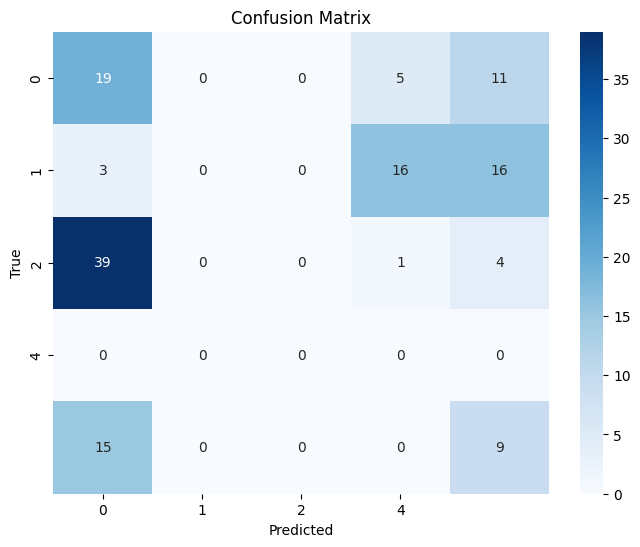

In [38]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Loss evaluation

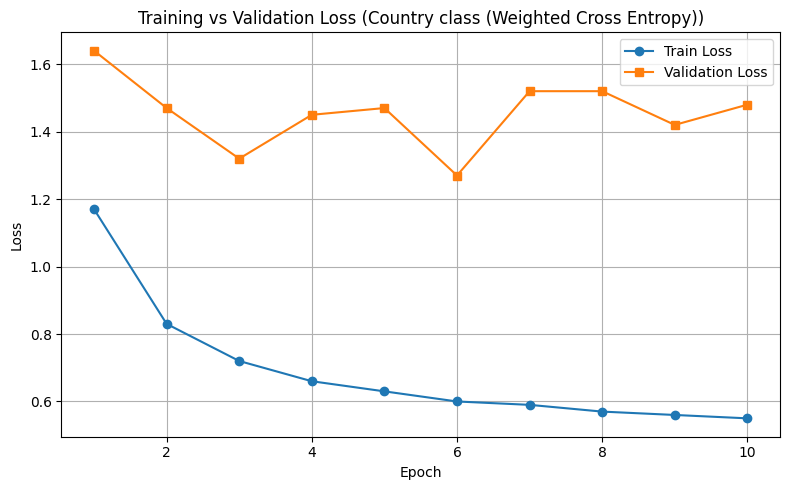

In [39]:
train_loss = [1.17,0.83,0.72,0.66,0.63,0.6,0.59,0.57,0.56,0.55]
val_loss = [1.64,1.47,1.32,1.45,1.47,1.27,1.52,1.52,1.42,1.48]
plot_loss(train_loss, val_loss, "Country class (Weighted Cross Entropy)")

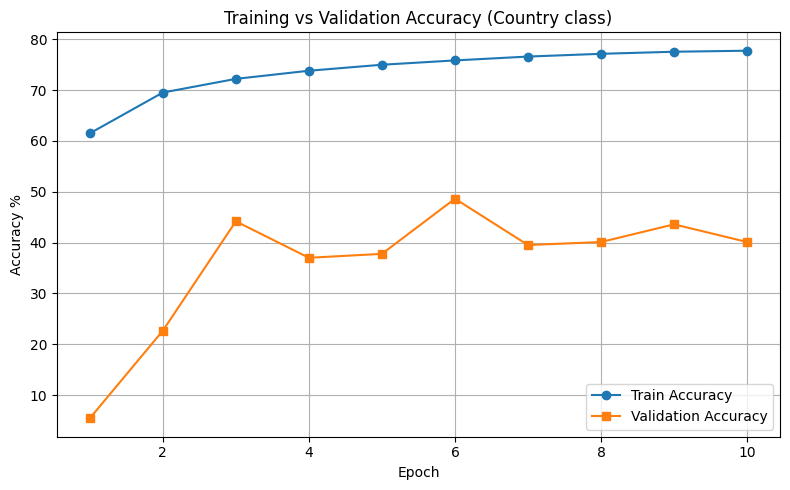

In [40]:
train_acc = [61.5,69.53,72.22,73.82,75.00,75.85,76.61,77.15,77.56,77.76]
val_acc = [5.43,22.67,44.19,37.02,37.79,48.64,39.53,40.12,43.6,40.12]
plot_acc(train_acc, val_acc, "Country class")

## Evaluate GPS prediction on hybrid model

In [41]:
dist = evaluate_geolocation_classification(merged)


Distance stats:
  Min:    4043.65 m
  Max:    338461.27 m
  Mean:   139158.91 m
  Median: 142193.09 m


In [42]:
print_recall_at_thresholds(dist, "Country class and simple regression", thresholds=[1000, 25000, 200000, 300000, 340000])


Recall for Country class and simple regression:
  Recall @ 1 km: 0.000
  Recall @ 25 km: 0.058
  Recall @ 200 km: 0.812
  Recall @ 300 km: 0.964
  Recall @ 340 km: 1.000


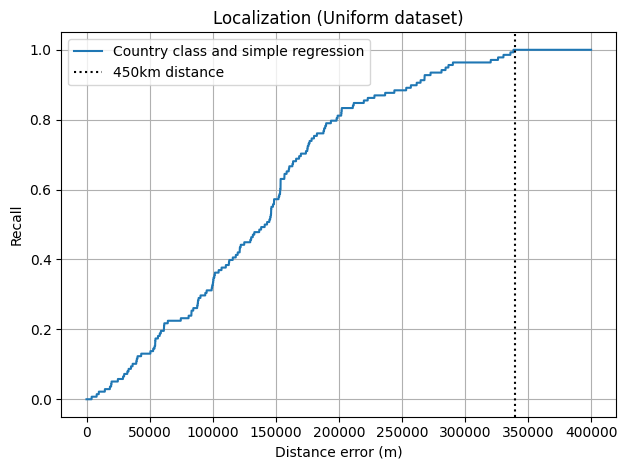

In [43]:
plot_recall_curve([dist], ["Country class and simple regression"])

## Admin1 classification

In [52]:
valid_images = set(gt_test["image"])
ac = pred_admin1_class[pred_admin1_class["image"].isin(valid_images)].copy()

In [59]:
merged = pd.merge(
    gt_test[["image", "admin1_id", 'latitude', 'longitude']],
    ac[["image", "predicted_class", 'latitude_radians', 'longitude_radians']],
    on="image"
)

In [57]:
merged["admin1_id"] = merged["admin1_id"].astype(int)
merged["predicted_class"] = merged["predicted_class"].astype(int)
y_true = merged["admin1_id"]
y_pred = merged["predicted_class"]

In [58]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2%}")

Accuracy: 0.65%


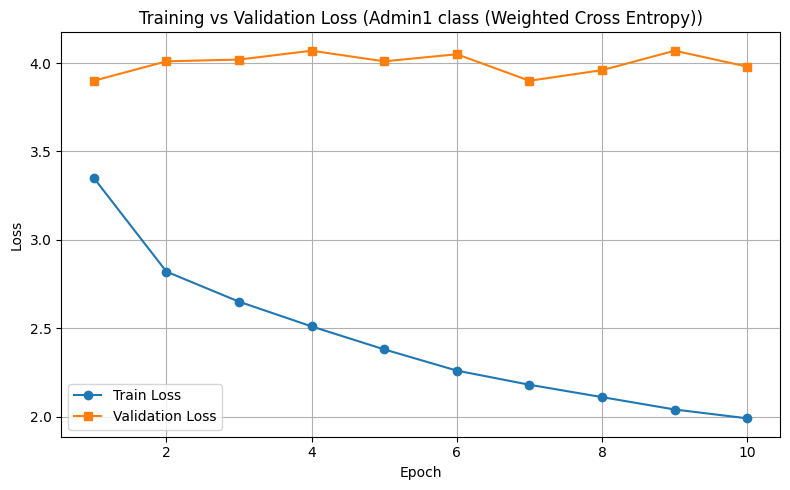

In [45]:
train_loss = [3.35,2.82,2.65,2.51,2.38,2.26,2.18,2.11,2.04,1.99]
val_loss = [3.9,4.01,4.02,4.07,4.01,4.05,3.9,3.96,4.07,3.98]
plot_loss(train_loss, val_loss, "Admin1 class (Weighted Cross Entropy)")

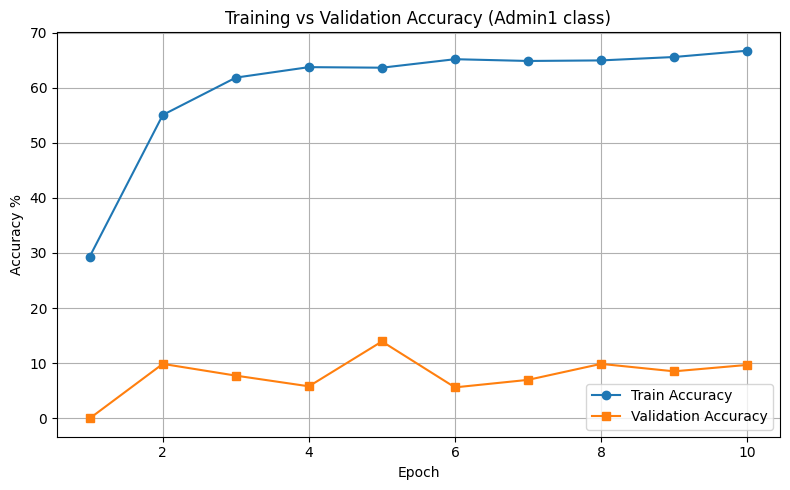

In [46]:
train_acc = [29.36,55.05,61.82,63.72,63.62,65.16,64.84,64.94,65.56,66.7]
val_acc = [0,9.88,7.75,5.81,13.95,5.62,6.98,9.88,8.53,9.69]
plot_acc(train_acc, val_acc, "Admin1 class")